# OpenDrift simulations forced by a regional ocean model (NEMO)

***

In [2]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from IPython.display import HTML
from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift

plt.rcParams['animation.html'] = 'html5'

***

## Define paths

Remote path from SSC-NEMO erddap server

In [3]:
# Define paths, grid, and mask
paths = {
    'erddap': 'https://salishsea.eos.ubc.ca/erddap/griddap',
    'local': '/data/bmoorema/results/opendrift',
}
grid = xr.open_dataset(os.path.join(paths['erddap'], 'ubcSSnBathymetryV17-02'))
mask = xr.open_dataset(os.path.join(paths['erddap'], 'ubcSSn3DMeshMaskV17-02'))

***

## Hydrodynamic forcing: SalishSeaCast (NEMO)

In [4]:
def plot_SSC_domain():
    """Plot the SalishSeaCast domain
    """

    # Draw map
    extent = [-126.5, -121.2, 46.8, 51.2]
    proj = crs.Mercator(np.mean(extent[:2]), *extent[2:])
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': proj})
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    ax.set_extent(extent)
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='burlywood'))

    # Overlay model domain and bathymetry
    c = ax.contourf(
        grid.longitude, grid.latitude, grid.bathymetry, levels=np.arange(0, 451, 50),
        cmap=cm.deep, extend='both', transform=crs.PlateCarree(), zorder=2,
    )
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'k']):
        getattr(ax, attr)(
            grid.longitude, grid.latitude, mask.tmask[0, 0, ...],
            levels=[-0.01, 0.01], colors=color, transform=crs.PlateCarree(), zorder=2,
        )
    lons, lats, corners = [], [], [(0, 0), (0, -1), (-1, -1), (-1, 0), (0, 0)]
    for i in corners: lons.append(grid.longitude[i]), lats.append(grid.latitude[i])
    ax.plot(lons, lats, 'k-', transform=crs.PlateCarree(), zorder=2)

    # Overlay gridlines and add colorbar
    xlocs, ylocs = [
        ticker.FixedLocator(np.arange(np.floor(lims[0]), np.ceil(lims[1])+1)) for lims in [extent[:2], extent[2:]]
    ]
    gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs)
    gl.xlabels_top = False
    gl.ylabels_right = False
    fig.colorbar(c, cax=cax, label='Depth [m]')

### Model domain and description

SalishSeaCast is a regional NEMO configuration on the Canadian Pacific south coast near Vancouver. The model domain has been rotated approximately 29$^{\circ}$ CCW from north to minimize open boundaries and land points. The rotation was done using Matlab orthogonal curvilinear grid creator, [Seagrid](https://github.com/sea-mat/seagrid), and thus has no formal `proj4` definition for the relation between lon/lat and x/y. I'm currently using `opendrift.readers.reader_netCDF_CF_unstructured` to load the NEMO results as a reader object, and could not find a better alternative.

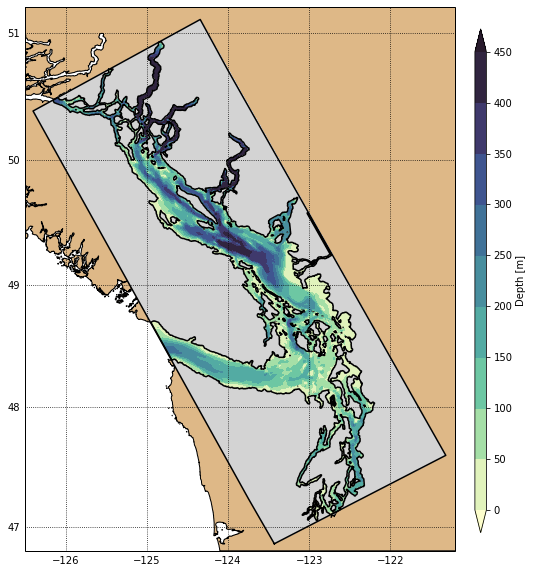

In [5]:
# Plot SSC domain
plot_SSC_domain()

***

## Local functions
For transforming water velocities from the model U and V grid points to lon/lat. (More sophisticated versions exist, these are used here for simplicity)

In [6]:
def unstagger(u, v):
    """Unstagger velocities from u,v points to t points
    """
    
    u = np.add(u[..., :-1], u[..., 1:]) / 2
    v = np.add(v[..., :-1, :], v[..., 1:, :]) / 2
    
    return u[..., 1:, :], v[..., 1:]

In [7]:
def rotate(u, v):
    """Rotate velocities from model grid to lon/lat space (29 deg)
    """

    theta = 29 * np.pi / 180
    u = u * np.cos(theta) - v * np.sin(theta)
    v = u * np.sin(theta) + v * np.cos(theta)

    return u, v

***

## Pre-process forcing files
Specify date range

In [8]:
# Daterange for simulation
daterange = [parse(d) for d in ['2017 Nov 10 00:00', '2017 Nov 20 00:00']]

Load and process SSC NEMO results from erddap

In [9]:
# Forcing path
fn = 'SalishSea_1h_' + '_'.join(d.strftime('%Y%m%d') for d in daterange) + '_opendrift.nc'
forcing_NEMO = os.path.join(paths['local'], 'forcing', fn)

# Load forcing data from ERDDAP
raw = []
for vel in ['u', 'v']:
    with xr.open_dataset(os.path.join(paths['erddap'], f'ubcSSg3D{vel}GridFields1hV18-06')) as data:
        time = data.time.sel(time=slice(*daterange))
        raw.append(data[f'{vel}Velocity'].sel(time=slice(*daterange))[:, 0, ...].values)

# Unstagger velocities to T points and rotate to lon/lat
u, v = rotate(*unstagger(*raw))

# Reshape, remove landpoints, and save to local netCDF path
tmask = mask.tmask[0, 0, 1:, 1:].values.reshape(-1).astype(bool)
ds = xr.Dataset(
    {
        'longitude': ('flat', grid.longitude[1:, 1:].values.reshape(-1)[tmask]),
        'latitude': ('flat', grid.latitude[1:, 1:].values.reshape(-1)[tmask]),
        'u': (['time', 'flat'], u.reshape(time.size, -1)[:, tmask], {'standard_name': 'x_sea_water_velocity'}),
        'v': (['time', 'flat'], v.reshape(time.size, -1)[:, tmask], {'standard_name': 'y_sea_water_velocity'}),
    },
    coords={'time': time}
).to_netcdf(forcing_NEMO)

***

## OpenDrift simulation
   * OceanDrift model
   * Unstructured netCDF reader
   * Basemap coastline
   * No wind forcing
   * 1 hour timestep
   * 4th order Runge-Kutta

In [20]:
# OpenDrift run configuration and parameters
o = OceanDrift(loglevel=20)
o.set_config('general:coastline_action', 'previous')
o.set_config('drift:scheme', 'runge-kutta4')
o.add_reader(reader_netCDF_CF_unstructured.Reader(forcing_NEMO))
o.seed_elements(-123.2, 49.0, radius=1000, time=daterange[0], number=500)

14:11:17 INFO: OpenDriftSimulation initialised (version 1.0.6)
14:11:17 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc
14:11:17 INFO: Opening file with Dataset


In [21]:
%%capture
# Run simulation
o.run(outfile='/data/bmoorema/results/opendrift/results/test.nc')

14:11:18 INFO: Config validation OK
14:11:18 INFO: Fallback values will be used for the following variables which have no readers: 
14:11:18 INFO: 	x_wind: 0.000000
14:11:18 INFO: 	y_wind: 0.000000
14:11:18 INFO: Duration, steps or end time not specified, running until end of first reader: 2017-11-19 23:30:00
14:11:18 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:11:32 INFO: Using existing reader for land_binary_mask
14:11:32 INFO: All points are in ocean
14:11:32 INFO: 2017-11-10 00:00:00 - step 1 of 239 - 500 active elements (0 deactivated)
14:11:33 INFO: 2017-11-10 01:00:00 - step 2 of 239 - 500 active elements (0 deactivated)
14:11:33 INFO: 2017-11-10 02:00:00 - step 3 of 239 - 500 active elements (0 deactivated)
14:11:33 INFO: 2017-11-10 03:00:00 - step 4 of 239 - 500 active elements (0 deactivated)
14:11:33 INFO: 2017-11-10 04:00:00 - step 5 of 239 - 500 active elements (0 deactivated)


14:11:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:41 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:41 INFO: 2017-11-11 02:00:00 - step 27 of 239 - 500 active elements (0 deactivated)
14:11:41 WARNING: Data block from /data/bmoorema/r

14:11:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:44 INFO: 2017-11-11 10:00:00 - step 35 of 239 - 500 active elements (0 deactivated)
14:11:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:45 WARNING: Data block from /data/bmoorema/r

14:11:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:48 INFO: 2017-11-11 19:00:00 - step 44 of 239 - 500 active elements (0 deactivated)
14:11:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:48 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:48 WARNING: Data block from /data/bmoorema/r

14:11:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:52 INFO: 2017-11-12 04:00:00 - step 53 of 239 - 500 active elements (0 deactivated)
14:11:52 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:52 WARNING: Data block from /data/bmoorema/r

14:11:54 INFO: 2017-11-12 12:00:00 - step 61 of 239 - 500 active elements (0 deactivated)
14:11:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:55 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:55 INFO: 2017-11-12 13:00:00 - step 62 of 23

14:11:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:58 INFO: 2017-11-12 21:00:00 - step 70 of 239 - 500 active elements (0 deactivated)
14:11:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:58 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:11:58 WARNING: Data block from /data/bmoorema/r

14:12:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:00 INFO: 2017-11-13 06:00:00 - step 79 of 239 - 500 active elements (0 deactivated)
14:12:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:00 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:00 WARNING: Data block from /data/bmoorema/r

14:12:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:03 INFO: 2017-11-13 15:00:00 - step 88 of 239 - 500 active elements (0 deactivated)
14:12:03 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:03 WARNING: Data block from /data/bmoorema/r

14:12:05 INFO: 2017-11-13 23:00:00 - step 96 of 239 - 500 active elements (0 deactivated)
14:12:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:05 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:05 INFO: 2017-11-14 00:00:00 - step 97 of 23

14:12:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:08 INFO: 2017-11-14 08:00:00 - step 105 of 239 - 500 active elements (0 deactivated)
14:12:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:08 WARNING: Data block from /data/bmoorema/

14:12:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:11 INFO: 2017-11-14 17:00:00 - step 114 of 239 - 500 active elements (0 deactivated)
14:12:11 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:11 WARNING: Data block from /data/bmoorema/

14:12:13 INFO: 2017-11-15 01:00:00 - step 122 of 239 - 500 active elements (0 deactivated)
14:12:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:13 INFO: 2017-11-15 02:00:00 - step 123 of 

14:12:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:16 INFO: 2017-11-15 10:00:00 - step 131 of 239 - 500 active elements (0 deactivated)
14:12:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:16 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:16 WARNING: Data block from /data/bmoorema/

14:12:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:19 INFO: 2017-11-15 19:00:00 - step 140 of 239 - 500 active elements (0 deactivated)
14:12:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:19 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:19 WARNING: Data block from /data/bmoorema/

14:12:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:22 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:23 INFO: 2017-11-16 04:00:00 - step 149 of 239 - 500 active elements (0 deactivated)
14:12:23 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:23 WARNING: Data block from /data/bmoorema/

14:12:26 INFO: 2017-11-16 12:00:00 - step 157 of 239 - 500 active elements (0 deactivated)
14:12:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:26 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:26 INFO: 2017-11-16 13:00:00 - step 158 of 

14:12:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:29 INFO: 2017-11-16 21:00:00 - step 166 of 239 - 500 active elements (0 deactivated)
14:12:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:29 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:30 WARNING: Data block from /data/bmoorema/

14:12:32 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:33 INFO: 2017-11-17 06:00:00 - step 175 of 239 - 500 active elements (0 deactivated)
14:12:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:33 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:33 WARNING: Data block from /data/bmoorema/

14:12:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:36 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:37 INFO: 2017-11-17 15:00:00 - step 184 of 239 - 500 active elements (0 deactivated)
14:12:37 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:37 WARNING: Data block from /data/bmoorema/

14:12:40 INFO: 2017-11-17 23:00:00 - step 192 of 239 - 500 active elements (0 deactivated)
14:12:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:40 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:40 INFO: 2017-11-18 00:00:00 - step 193 of 

14:12:43 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:44 INFO: 2017-11-18 08:00:00 - step 201 of 239 - 500 active elements (0 deactivated)
14:12:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:44 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:44 WARNING: Data block from /data/bmoorema/

14:12:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:47 INFO: 2017-11-18 17:00:00 - step 210 of 239 - 500 active elements (0 deactivated)
14:12:47 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:47 WARNING: Data block from /data/bmoorema/

14:12:50 INFO: 2017-11-19 01:00:00 - step 218 of 239 - 500 active elements (0 deactivated)
14:12:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:50 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:51 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:51 INFO: 2017-11-19 02:00:00 - step 219 of 

14:12:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:54 INFO: 2017-11-19 10:00:00 - step 227 of 239 - 500 active elements (0 deactivated)
14:12:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:54 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:54 WARNING: Data block from /data/bmoorema/

14:12:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:57 INFO: 2017-11-19 19:00:00 - step 236 of 239 - 500 active elements (0 deactivated)
14:12:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:57 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171110_20171120_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:12:57 WARNING: Data block from /data/bmoorema/

In [22]:
%%capture
# Make animation
anim = o.animation()

In [23]:
# Display animation
HTML(anim.to_html5_video())

14:13:08 INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:13:08 INFO: figure size (inches) has been adjusted from 9.99810558584112 x 10.0 to 9.972222222222221 x 10.0
14:13:08 INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '718x720', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpp2rovilb/temp.m4v']
